### Bibliotecas

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install mmh3

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

### Carregamento e Tratamento dos Dados

In [ ]:
# Datasets
treino = pd.read_csv('./drive/MyDrive/trab-redes/PCAPS/dataset1.csv')
teste = pd.read_csv('./drive/MyDrive/trab-redes/PCAPS/dataset2.csv')

# teste = pd.read_csv('./drive/MyDrive/trab-redes/PCAPS/dataset1.csv')
# treino = pd.read_csv('./drive/MyDrive/trab-redes/PCAPS/dataset2.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Ordena pelo tempo:
treino.sort_values(by=['Time'], inplace=True)
teste.sort_values(by=['Time'], inplace=True)

# Filtra apenas os pacotes do tipo TCP:
treino = treino[treino.Protocol == 'TCP']
teste = teste[teste.Protocol == 'TCP']

# Divide em intervalos de 5 segundos para visualização
treino_2 = treino.groupby(pd.cut(treino["Time"], np.arange(0, treino['Time'].iloc[-1]+1, 5)))['Length'].sum().reset_index()
teste_2 = teste.groupby(pd.cut(teste["Time"], np.arange(0, teste['Time'].iloc[-1]+1, 5)))['Length'].sum().reset_index()
treino_2['index1'] = treino_2.index
teste_2['index1'] = teste_2.index

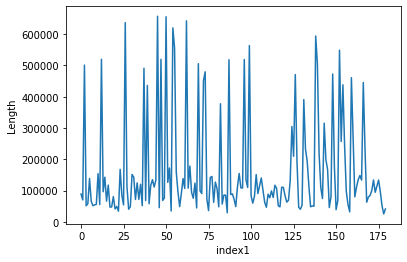

In [ ]:
# Podemos visualizar o número de bytes por intervalo de tempo:
sns.lineplot(data=teste_2, x="index1", y="Length");

In [ ]:
# Preenche uma estrutura probabilística a partir de um dataframe de pcap:
from mmh3 import hash, hash64, hash128

# Adicionar portas de origem/dest ao hash
def estrutura(df, ti=5, counter_size=1000):

  # Contadores:
  contadores = []
  contador = [0] * counter_size

  # Tempo do primeiro pacote
  time = df.iloc[0].Time
  tempo_anterior = time

  # Para cada pacote
  for idx, row in df.iterrows():

    # Se passaram "ti" segundos, troca o contador
    if row.Time > time+ti:
      contadores.append({"contador": contador, "start": time, "end": tempo_anterior} )
      contador = [0] * 100000
      time = time + ti

    tempo_anterior = row.Time

    # Faz o parsing das portas de origem e destino
    try:
      portas = row.Info.split(' [')[0]
      porta_source, porta_dest = portas.split('>')
    except:
      porta_source = porta_dest = ''

    # Aplica o hash aos IPs e portas de origem e destino:
    # hash_result = str(hash("" + row.Source + row.Destination + porta_source.strip() + porta_dest.strip(), signed=False))
    hash_result = str(hash(f"{row.Source} {row.Destination} {porta_source} {porta_dest}", signed=False))
    hash_result = int(hash_result[:len(str(counter_size))-1])
    
    # Soma o tamanho do pacote ao contador:
    contador[hash_result] += int(row.Length)

  contadores.append({"contador": contador, "start": time, "end": tempo_anterior} )

  return contadores

contadores_treino = estrutura(treino)
contadores_teste = estrutura(teste)

In [ ]:
print(len(contadores_treino), len(contadores_teste))

181 181


In [ ]:
# Extrai features da estrurura:

# Como temos poucas stations, a estrutura tem muitos zeros e isso torna algumas métricas pouco sensíveis,
# então sugiro calcularmos as mesmas apenas para os não-zeros.
def features(est):
  est = np.array(est)
  est_non_zeros = est[est != 0] # Lista sem o zeros
  total = np.sum(est_non_zeros)
  non_zeros = np.count_nonzero(est)
  max = np.amax(est_non_zeros)
  max_idx = np.argmax(est_non_zeros)
  mean = np.mean(est_non_zeros)
  desv = np.std(est_non_zeros)
  twotimes = (est_non_zeros < (mean + 2*desv)).sum()
  threetimes = (est_non_zeros < (mean + 3*desv)).sum()
  mediana = np.median(est_non_zeros)

  return {"Total": total, "NonZeros": non_zeros, "Max": max, "MaxIdx": max_idx, "Mean": mean, "Desv": desv, "TwoTimes": twotimes, "TheeTimes": threetimes, "Mediana": mediana}

# Dados Treino:
dados_treino = []
for c in contadores_treino:
  dados_treino.append(features(c['contador']))

# Dados Teste:
dados_teste = []
for c in contadores_teste:
  dados_teste.append(features(c['contador']))

result_treino = pd.DataFrame(dados_treino)
result_teste = pd.DataFrame(dados_teste)

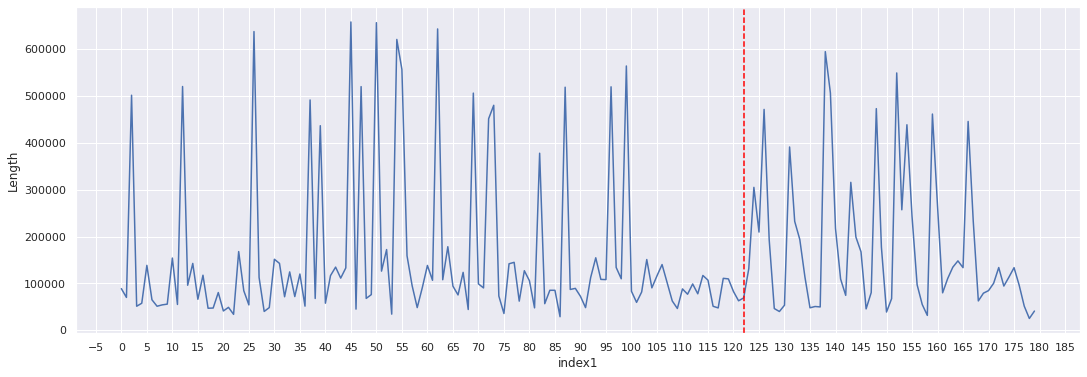

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set(rc={'figure.figsize':(18,6)})
f = sns.lineplot(data=teste_2, x="index1", y="Length");
f.xaxis.set_major_locator(MultipleLocator(5));
plt.axvline(122, 0, 600000, color='red', linestyle="--");

In [ ]:
# Flows de cada intervalo (5 segundos)
flows_treino = ['M'] * 181
elephants_treino = [13,19,22,31,34,36,37,40,41,52,53,54,55,56,76,101,111,114,117,118,121,126,130,137,139,155,164,170,172,173]
for i in elephants_treino:
  flows_treino[i] = 'E'


flows_teste = ['M'] * 181
elephants_teste = [1,11,25, 36, 38, 44, 46, 49, 53, 54, 61, 68, 71, 72, 86, 95, 98, 123, 124, 125, 130, 137, 138, 142, 143, 147, 151, 153, 158, 165]
elephants_teste = [x+1 for x in elephants_teste]
for i in elephants_teste:
  flows_teste[i] = 'E'

print(len(elephants_treino), len(elephants_teste))

30 30


In [ ]:
# Normalizando os datasets:
result_treino = (result_treino - result_treino.mean()) / result_treino.std()
result_teste = (result_teste - result_teste.mean()) / result_teste.std()

In [ ]:
# temp = flows_treino
# flows_treino = flows_teste
# flows_teste = temp

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(3,4), random_state=1, validation_fraction=0.33, max_iter=5000);
clf.fit(result_treino, flows_treino);

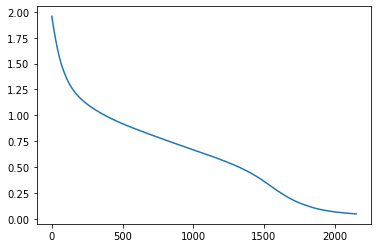

In [ ]:
sns.reset_orig()
sns.lineplot(x=range(len(clf.loss_curve_)), y=clf.loss_curve_);

In [ ]:
clf.best_loss_

0.0482862464738265

In [ ]:
clf.score(result_teste, flows_teste)

0.9779005524861878

In [ ]:
y_pred = clf.predict(result_teste)

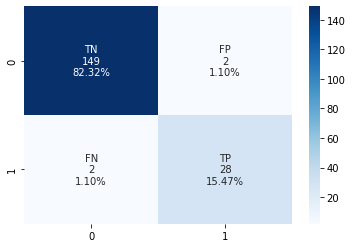

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(flows_teste, y_pred, labels=['M', 'E'])

group_names = ['TN','FP','FN','TP']
group_counts = [f'{value}' for value in cf_matrix.flatten()]
group_percentages = ["{:2.2f}%".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)*100]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

nb = GaussianNB()
ada = AdaBoostClassifier(n_estimators=100, random_state=1)
rf = RandomForestClassifier(max_depth=3, random_state=1)
rn = MLPClassifier(hidden_layer_sizes=(50, 50), random_state=1, validation_fraction=0.33, max_iter=5000);


nb.fit(result_treino, flows_treino);
ada.fit(result_treino, flows_treino);
rf.fit(result_treino, flows_treino);
rn.fit(result_treino, flows_treino);

nb_pred = nb.predict(result_teste);
ada_pred = ada.predict(result_teste);
rf_pred = rf.predict(result_teste);
rn_pred = rn.predict(result_teste);

In [ ]:
print(rn.score(result_teste, flows_teste))

0.9779005524861878


In [ ]:
confusion_matrix(flows_teste, rn_pred, labels=['M', 'E'])

array([[149,   2],
       [  2,  28]])

In [ ]:
rn = MLPClassifier(hidden_layer_sizes=(50, 50, 50), random_state=1, validation_fraction=0.33, max_iter=5000);

In [ ]:
erros = 0
acertos = 0
FP = 0
FN = 0
TP = 0
TN = 0
for i in range(len(y_pred)):
  if y_pred[i] != flows_teste[i]:
    erros += 1
    if y_pred[i] == 'E' and flows_teste[i] == 'M': FP += 1
    if y_pred[i] == 'M' and flows_teste[i] == 'E': FN += 1
  else:
    acertos += 1
    if y_pred[i] == 'E' and flows_teste[i] == 'E': TP += 1
    if y_pred[i] == 'M' and flows_teste[i] == 'M': TN += 1
print(acertos, erros)
print(TP, TN)
print(FP, FN)

131 50
5 126
25 25


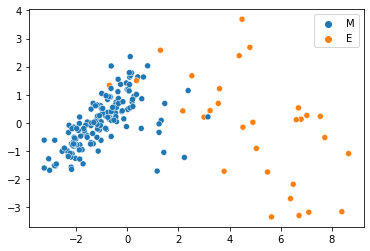

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=9)
result_pca = pca.fit_transform(result_treino)
sns.scatterplot(x=result_pca[:,0], y=result_pca[:,1], hue=flows_treino)

In [ ]:
pca.explained_variance_ratio_

array([7.63874719e-01, 1.39453713e-01, 7.19261605e-02, 1.23002282e-02,
       8.88623399e-03, 2.36976235e-03, 7.46955437e-04, 4.01248952e-04,
       4.09788607e-05])